In [2]:
import argparse
import gc
import os
import warnings
import sys; sys.path.append('/home/kazuki/workspace/kaggle_bengali')
import cv2
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm
import albumentations
from datasets.dataset_factory import KaggleDataset, make_loader
from losses.loss_factory import get_criterion
from models.model_factory import get_model
from optimizers.optimizer_factory import get_optimizer
from schedulers.scheduler_factory import get_scheduler
# from transformars.transform_factory import get_transforms
from transformars.transform_factory import GridMask, Transform, apply_aug
from utils.config import load_config, save_config
from utils.metrics import macro_recall_multi
from utils.utils import (cutmix, cutmix_criterion, get_logger, mixup,
                         mixup_criterion, ohem_loss, rand_bbox)


In [3]:
all_transforms = {}
all_transforms['train'] = Transform(size=128)
all_transforms['valid'] = Transform(size=128)

In [4]:
dataloaders = {
    phase: make_loader(
        phase=phase,
        batch_size=4,
        num_workers=1,
        idx_fold=0,
        fold_csv='train_with_fold_seed12.csv',
        transforms=all_transforms[phase],
        # debug=config.debug
    )
    for phase in ['train', 'valid']
}

In [120]:
dataiter = iter(dataloaders["train"])

In [6]:
def imshow(img):     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [23]:
inputs = next(dataiter)['images']

In [76]:
x = inputs[0].squeeze(0)

In [77]:
x.numpy()

array([[-0.3373964, -0.3373964, -0.3373964, ..., -0.3373964, -0.3373964,
        -0.3373964],
       [-0.3373964, -0.3373964, -0.3373964, ..., -0.3373964, -0.3373964,
        -0.3373964],
       [-0.3373964, -0.3373964, -0.3373964, ..., -0.3373964, -0.3373964,
        -0.3373964],
       ...,
       [-0.3373964, -0.3373964, -0.3373964, ..., -0.3373964, -0.3373964,
        -0.3373964],
       [-0.3373964, -0.3373964, -0.3373964, ..., -0.3373964, -0.3373964,
        -0.3373964],
       [-0.3373964, -0.3373964, -0.3373964, ..., -0.3373964, -0.3373964,
        -0.3373964]], dtype=float32)

In [78]:
x = x.numpy()

In [100]:
k = apply_aug(RandomAugMix(severity=7, width=1, p=1.), x.astype(np.float32))

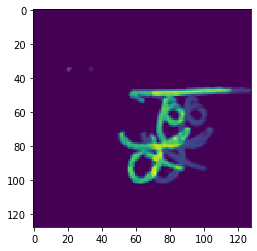

In [101]:
plt.imshow(k)

In [56]:
x = cv2.resize(x.numpy(), (64, 64))

In [22]:
x.shape

(128, 128)

In [10]:
from transformars.aug_mix import RandomAugMix
from transformars.grid_mask import GridMask

In [60]:
x = apply_aug(GridMask(num_grid=3, p=1), x)

In [102]:
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir + f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir + f'{data_type}_image_data_{i}.feather')
                         for i in indices]
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [104]:
df_path='/home/kazuki/workspace/kaggle_bengali/data/input/'
train_images = prepare_image(
        df_path, df_path, data_type='train', submission=False, indices = [1])

In [105]:
image = train_images[2]

In [107]:
image.shape

(137, 236)

In [108]:
image = cv2.resize(image, (128, 128))

In [140]:
x.shape

(128, 128)

In [172]:
RandomAugMix(severity=7, width=1, p=1.)(image=x)['image']

OSError: not supported for this image mode

In [154]:
apply_aug(RandomAugMix(severity=7, width=1, p=1.), image)

array([[ 9.46080589,  8.48122722,  7.50164902, ..., 17.30764371,
        17.2974329 , 11.41996276],
       [ 6.52207059,  7.51185983,  8.48122722, ..., 14.35869735,
        12.39954096,  9.46080589],
       [ 6.52207059,  6.5322814 ,  8.49143803, ..., 11.41996276,
        11.41996276, 11.41996276],
       ...,
       [ 3.59354627,  3.59354627,  3.58333546, ...,  2.60375708,
         2.60375708,  2.60375708],
       [ 3.58333546,  3.58333546,  3.58333546, ...,  2.60375708,
         2.60375708,  2.60375708],
       [ 3.58333546,  3.58333546,  3.58333546, ...,  2.60375708,
         2.60375708,  2.60375708]])

In [121]:
inputs = next(dataiter)['images']

In [122]:
inputs.shape

torch.Size([4, 1, 128, 128])

In [135]:
for i in range(len(inputs)):
    x = apply_aug(RandomAugMix(severity=7, width=1, p=1.),inputs[i].squeeze(0).numpy())
    

OSError: not supported for this image mode

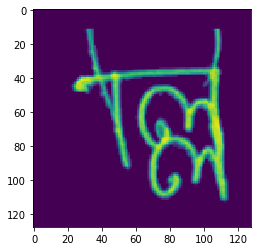

In [138]:
plt.imshow(inputs[i].squeeze(0).numpy())

In [139]:
image

array([[248, 249, 250, ..., 241, 240, 246],
       [251, 251, 249, ..., 243, 245, 248],
       [251, 252, 250, ..., 246, 246, 246],
       ...,
       [255, 255, 254, ..., 255, 255, 255],
       [254, 254, 254, ..., 255, 255, 255],
       [254, 254, 254, ..., 255, 255, 255]], dtype=uint8)

In [143]:
x

array([[-0.21573313, -0.21573313, -0.21573313, ..., -0.21573313,
        -0.21573313, -0.21573313],
       [-0.21573313, -0.21573313, -0.21573313, ..., -0.21573313,
        -0.21573313, -0.21573313],
       [-0.21573313, -0.21573313, -0.21573313, ..., -0.21573313,
        -0.21573313, -0.21573313],
       ...,
       [-0.33739644, -0.33739644, -0.33739644, ..., -0.21573313,
        -0.21573313, -0.21573313],
       [-0.33739644, -0.33739644, -0.33739644, ..., -0.21573313,
        -0.21573313, -0.21573313],
       [-0.33739644, -0.33739644, -0.33739644, ..., -0.21573313,
        -0.21573313, -0.21573313]], dtype=float32)

In [148]:
from skimage.transform import AffineTransform, warp
def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image

In [174]:
image = (255 - image).astype(np.float32) / 255.

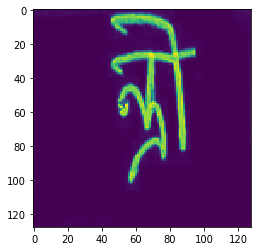

In [175]:
plt.imshow(image)

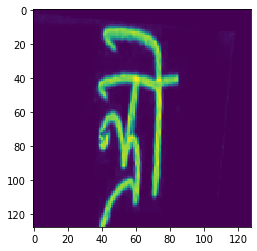

In [185]:
plt.imshow(affine_image(image))

In [186]:
aff = affine_image(image)

In [152]:
aff.shape

(128, 128)

In [187]:
from PIL import Image, ImageEnhance, ImageOps

In [188]:
image

array([[0.02745098, 0.02352941, 0.01960784, ..., 0.05490196, 0.05882353,
        0.03529412],
       [0.01568628, 0.01568628, 0.02352941, ..., 0.04705882, 0.03921569,
        0.02745098],
       [0.01568628, 0.01176471, 0.01960784, ..., 0.03529412, 0.03529412,
        0.03529412],
       ...,
       [0.        , 0.        , 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [189]:
def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

In [190]:
pil_img = Image.fromarray(image) 

In [191]:
pil_img = op(pil_img, 7)

NameError: name 'op' is not defined